<a href="https://colab.research.google.com/github/bangaruprasanna/Credit-Card-Fraud-Detection-System/blob/main/Credit_Card_Fraud_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_transactions = 10000
fraud_percentage = 0.05

data = {
    'transaction_id': np.arange(n_transactions),
    'user_id': np.random.randint(1000, 9999, n_transactions),
    'amount': np.round(np.abs(np.random.normal(50, 30, n_transactions)), 2),
    'time': np.random.uniform(0, 24, n_transactions),  # Hour of day
    'category': np.random.choice(['grocery', 'gas', 'shopping', 'food', 'travel'], n_transactions),
    'merchant': np.random.choice(['Walmart', 'Amazon', 'Shell', 'Starbucks', 'Expedia'], n_transactions),
    'location': np.random.choice(['NY', 'CA', 'TX', 'FL', 'IL'], n_transactions),
    'device': np.random.choice(['mobile', 'desktop', 'tablet'], n_transactions),
    'ip_address': [f"{np.random.randint(1,255)}.{np.random.randint(1,255)}.x.x" for _ in range(n_transactions)],
    'is_fraud': np.random.choice([0, 1], n_transactions, p=[1-fraud_percentage, fraud_percentage])
}

# Make frauds more expensive and at odd hours
fraud_mask = data['is_fraud'] == 1
data['amount'][fraud_mask] = np.round(np.abs(np.random.normal(150, 100, sum(fraud_mask))), 2)
data['time'][fraud_mask] = np.random.uniform(0, 6, sum(fraud_mask))  # More frauds at night

df = pd.DataFrame(data)
df.to_csv('credit_card_transactions.csv', index=False)

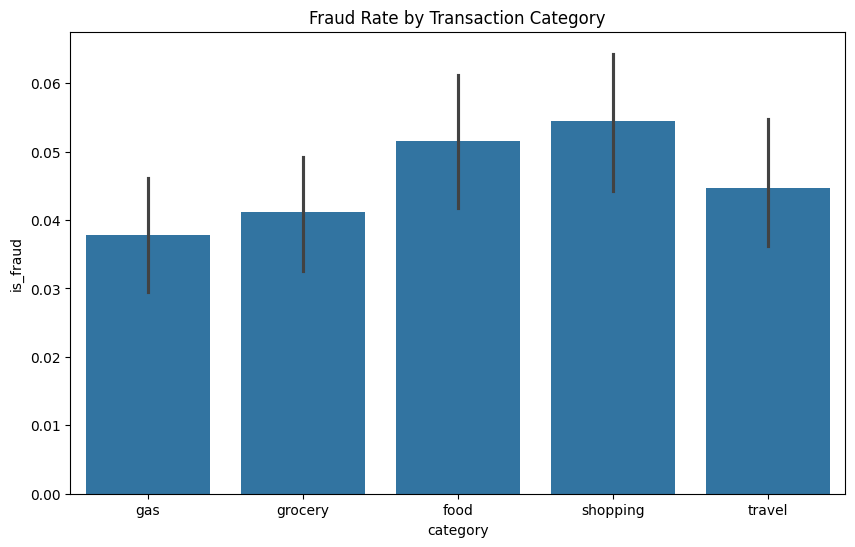

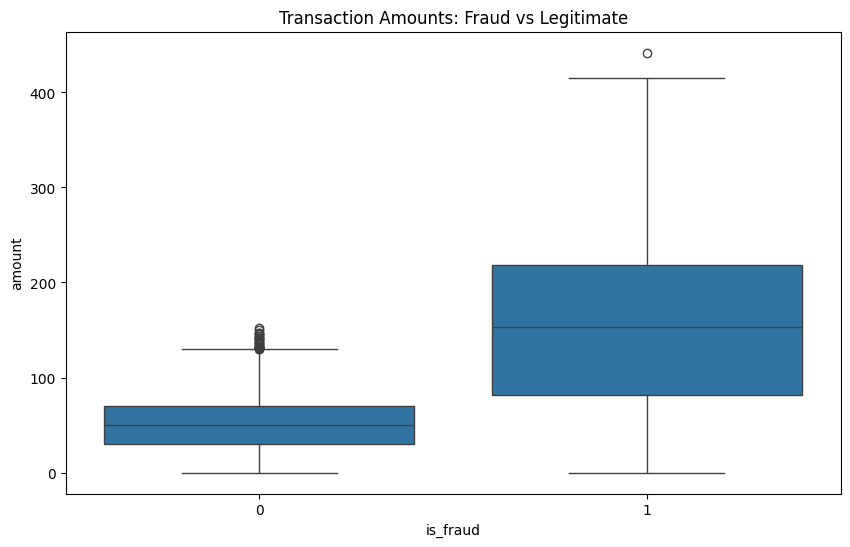

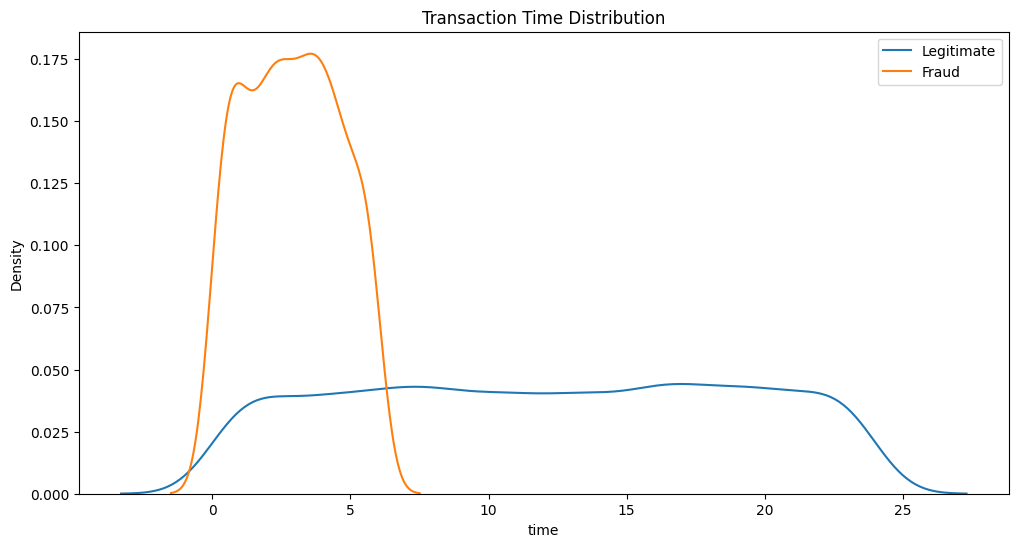

ValueError: could not convert string to float: 'Shell'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fraud rate by category
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='category', y='is_fraud', estimator=np.mean)
plt.title('Fraud Rate by Transaction Category')
plt.show()

# Amount distribution by fraud status
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='is_fraud', y='amount')
plt.title('Transaction Amounts: Fraud vs Legitimate')
plt.show()

# Fraud by hour of day
plt.figure(figsize=(12,6))
sns.kdeplot(data=df[df['is_fraud']==0], x='time', label='Legitimate')
sns.kdeplot(data=df[df['is_fraud']==1], x='time', label='Fraud')
plt.title('Transaction Time Distribution')
plt.legend()
plt.show()

# Time-based features
df['hour_of_day'] = df['time'].apply(lambda x: int(x))
df['is_night'] = df['hour_of_day'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Transaction frequency (simulated)
df['transactions_last_24h'] = np.random.randint(1, 20, len(df))
df.loc[df['is_fraud']==1, 'transactions_last_24h'] = np.random.randint(15, 50, sum(df['is_fraud']==1))

# Average transaction amount (simulated)
df['avg_amount_last_7d'] = np.round(np.abs(np.random.normal(50, 20, len(df))), 2)
df.loc[df['is_fraud']==1, 'avg_amount_last_7d'] = np.round(np.abs(np.random.normal(30, 15, sum(df['is_fraud']==1))), 2)

# Convert categorical to numerical
df = pd.get_dummies(df, columns=['category', 'location', 'device'])

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Features and target
X = df.drop(['transaction_id', 'user_id', 'ip_address', 'is_fraud', 'time'], axis=1)
y = df['is_fraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.4f}")

# Feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features for Fraud Detection')
plt.show()

